<a href="https://colab.research.google.com/github/chachak410/ai-design-generator/blob/main/ai_design_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# Step 0: Setup
!pip -q install requests pillow

import os, time, json, base64, urllib.parse, requests, textwrap
from io import BytesIO
from PIL import Image
from datetime import datetime
from IPython.display import display, HTML

# Optional: set these if you have keys (leave blank to skip)
os.environ["REPLICATE_API_TOKEN"] = os.getenv("REPLICATE_API_TOKEN", "")
os.environ["DEEPAI_API_KEY"] = os.getenv("DEEPAI_API_KEY", "")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN", "")

# Output directory
OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [29]:
# Step 1: Define interface inputs
ui_params = {
    "company": "Luna Beauty",
    "product_name": "HydraGlaze Lip Oil",
    "target_audience": "Gen Z women interested in clean beauty",
    "tone": "warm, aspirational, friendly",
    "style": "minimalist studio lighting, glossy macro product shot, soft shadows",
    "message": "Instant hydration with a non-sticky glossy finish",
    "benefits": ["non-sticky", "hydrating", "glossy", "vegan"],
    "color_palette": ["#FF6FA5", "#FFCFE3", "#FFFFFF"],
    "image_count": 3,            # how many images to generate
    "aspect_ratio": "3:4",       # 1:1, 3:4, 4:3, 9:16, 16:9
    "seed": 12345,               # optional; set to None for random
    "extra": "avoid text; clean white background; no watermark"
}
ui_params

{'company': 'Luna Beauty',
 'product_name': 'HydraGlaze Lip Oil',
 'target_audience': 'Gen Z women interested in clean beauty',
 'tone': 'warm, aspirational, friendly',
 'style': 'minimalist studio lighting, glossy macro product shot, soft shadows',
 'message': 'Instant hydration with a non-sticky glossy finish',
 'benefits': ['non-sticky', 'hydrating', 'glossy', 'vegan'],
 'color_palette': ['#FF6FA5', '#FFCFE3', '#FFFFFF'],
 'image_count': 3,
 'aspect_ratio': '3:4',
 'seed': 12345,
 'extra': 'avoid text; clean white background; no watermark'}

In [30]:
# Step 2: Prompt builders

def build_base_description(p):
    benefits = ", ".join(p.get("benefits", []))
    colors = ", ".join(p.get("color_palette", []))
    return (
        f"High-quality product image for {p['product_name']} by {p['company']}. "
        f"Audience: {p['target_audience']}. Tone: {p['tone']}. "
        f"Style: {p['style']}. Message: {p['message']}. "
        f"Benefits: {benefits}. Colors: {colors}. {p.get('extra','')}"
    ).strip()

def generate_llm_instruction_prompts(p):
    base_desc = build_base_description(p)
    schema_hint = textwrap.dedent("""
    Return JSON with:
    {
      "prompt": "<single concise image-generation prompt>",
      "negative_prompt": "<unwanted elements, optional>",
      "style": "<concise style tags>",
      "seed": "<integer or null>"
    }
    """).strip()

    openai_prompt = f"""
    You are a senior prompt engineer. Convert the following product brief into a single, production-quality image-generation prompt suitable for SDXL/Flux-type models. Be concise and concrete, avoid camera jargon unless critical. {schema_hint}

    Brief:
    {base_desc}
    """.strip()

    anthropic_prompt = f"""
    System: You are an expert prompt engineer for image models. Output only JSON and nothing else.

    User: Convert this product brief into a single image-generation prompt. {schema_hint}

    Brief:
    {base_desc}
    """.strip()

    gemini_prompt = f"""
    Role: Expert image prompt designer.
    Task: Convert the brief into a single, model-ready prompt with optional negative prompt. {schema_hint}

    Brief:
    {base_desc}
    """.strip()

    return {
        "openai": openai_prompt,
        "anthropic": anthropic_prompt,
        "gemini": gemini_prompt
    }

def provider_style_prompts(p):
    base_desc = build_base_description(p)
    # Lightly different flavors to test what works better with various generators
    prompts = {
        "sdxl_style": f"{base_desc}. ultra-detailed, studio lighting, sharp focus, photorealistic, 8k, product hero shot",
        "flux_style": f"{base_desc}. modern commercial aesthetic, soft gradients, directional key light, realistic materials, subtle reflections, product-centric composition",
        "midjourney_style": f"{base_desc} --stylize 250 --ar {p['aspect_ratio']} --no text, watermark, logo"
    }
    return prompts

llm_prompts = generate_llm_instruction_prompts(ui_params)
styled_prompts = provider_style_prompts(ui_params)

print("LLM Instruction Prompts (copy for your LLMs):\n")
for k,v in llm_prompts.items():
    print(f"--- {k.upper()} ---\n{v}\n")

print("Provider-Style Image Prompts:\n")
for k,v in styled_prompts.items():
    print(f"--- {k} ---\n{v}\n")


LLM Instruction Prompts (copy for your LLMs):

--- OPENAI ---
You are a senior prompt engineer. Convert the following product brief into a single, production-quality image-generation prompt suitable for SDXL/Flux-type models. Be concise and concrete, avoid camera jargon unless critical. Return JSON with:
{
  "prompt": "<single concise image-generation prompt>",
  "negative_prompt": "<unwanted elements, optional>",
  "style": "<concise style tags>",
  "seed": "<integer or null>"
}

    Brief:
    High-quality product image for HydraGlaze Lip Oil by Luna Beauty. Audience: Gen Z women interested in clean beauty. Tone: warm, aspirational, friendly. Style: minimalist studio lighting, glossy macro product shot, soft shadows. Message: Instant hydration with a non-sticky glossy finish. Benefits: non-sticky, hydrating, glossy, vegan. Colors: #FF6FA5, #FFCFE3, #FFFFFF. avoid text; clean white background; no watermark

--- ANTHROPIC ---
System: You are an expert prompt engineer for image models. 

In [31]:
# Step 3: Choose final prompt for image generation
final_image_prompt = styled_prompts["flux_style"]  # choose: "sdxl_style" or "flux_style"
print("Final image prompt:\n", final_image_prompt)

Final image prompt:
 High-quality product image for HydraGlaze Lip Oil by Luna Beauty. Audience: Gen Z women interested in clean beauty. Tone: warm, aspirational, friendly. Style: minimalist studio lighting, glossy macro product shot, soft shadows. Message: Instant hydration with a non-sticky glossy finish. Benefits: non-sticky, hydrating, glossy, vegan. Colors: #FF6FA5, #FFCFE3, #FFFFFF. avoid text; clean white background; no watermark. modern commercial aesthetic, soft gradients, directional key light, realistic materials, subtle reflections, product-centric composition


In [32]:
# Combined Step 4: Image generation helpers (all providers in one cell)

import os, time, base64, urllib.parse, requests, subprocess, sys
from io import BytesIO
from PIL import Image
from datetime import datetime

# Environment variables (set here or via Runtime > Environment variables)
DEEPAI_API_KEY = os.getenv("DEEPAI_API_KEY", "")
REPLICATE_API_TOKEN = os.getenv("REPLICATE_API_TOKEN", "")
HF_TOKEN = os.getenv("HF_TOKEN", "")
HORDE_API_KEY = os.getenv("HORDE_API_KEY", "0000000000")  # anonymous key allowed

# Stable Horde base URL
HORDE_API = "https://stablehorde.net/api/v2"

# Output directory if not defined earlier
OUT_DIR = globals().get("OUT_DIR", "/content/outputs")
os.makedirs(OUT_DIR, exist_ok=True)

def aspect_to_size(ar):
    table = {
        "1:1": (768, 768),
        "3:4": (768, 1024),
        "4:3": (1024, 768),
        "9:16": (768, 1365),
        "16:9": (1365, 768),
    }
    return table.get((ar or "").strip(), (768, 1024))

# -------- Free provider: Pollinations (no key) --------
def gen_pollinations(prompt, n, width, height, seed=None):
    items = []
    quoted = urllib.parse.quote(prompt)
    base = f"https://image.pollinations.ai/prompt/{quoted}?width={width}&height={height}&n=1"
    for i in range(n):
        s = (seed if isinstance(seed, int) else int(time.time() * 1000)) + i
        url = f"{base}&seed={s}"
        items.append({"provider": "pollinations", "url": url})
    return items

# -------- Free provider: Stable Horde (no key required; key improves queue priority) --------
def _horde_submit_job(prompt, width, height, seed=None, steps=28, cfg_scale=7):
    # Keep sizes multiples of 64
    width = int(round(width / 64) * 64)
    height = int(round(height / 64) * 64)
    payload = {
        "prompt": prompt,
        "params": {
            "sampler_name": "k_euler",
            "cfg_scale": cfg_scale,
            "seed": int(seed) if seed is not None else None,
            "steps": steps,
            "width": width,
            "height": height,
        },
        "nsfw": False,
        "censor_nsfw": True,
        "trusted_workers": False,
        "slow_workers": True,  # allow the public pool
        # Optionally pin to a model (may increase wait times):
        # "models": ["SDXL 1.0"],
    }
    headers = {"apikey": HORDE_API_KEY, "accept": "application/json", "Content-Type": "application/json"}
    r = requests.post(f"{HORDE_API}/generate/async", headers=headers, json=payload, timeout=60)
    r.raise_for_status()
    j = r.json()
    if "id" not in j:
        raise RuntimeError(f"Horde submit failed: {j}")
    return j["id"]

def _horde_poll_status(job_id, max_wait_sec=180, poll_every=3):
    headers = {"apikey": HORDE_API_KEY, "accept": "application/json"}
    start = time.time()
    while True:
        r = requests.get(f"{HORDE_API}/generate/status/{job_id}", headers=headers, timeout=60)
        r.raise_for_status()
        j = r.json()
        if j.get("done") and j.get("generations"):
            return j
        if time.time() - start > max_wait_sec:
            raise TimeoutError(f"Horde job timed out after {max_wait_sec}s")
        time.sleep(poll_every)

def gen_stable_horde(prompt, n, width, height, seed=None, steps=28, cfg_scale=7):
    items = []
    for i in range(n):
        job_seed = (seed + i) if isinstance(seed, int) else None
        job_id = _horde_submit_job(prompt, width, height, seed=job_seed, steps=steps, cfg_scale=cfg_scale)
        status = _horde_poll_status(job_id)
        gens = status.get("generations", [])
        for g in gens:
            b64 = g.get("img")
            if b64:
                items.append({"provider": "stable_horde", "b64": b64})
                break  # take the first image per job
    return items

# -------- Optional providers (require keys) --------
def gen_deepai(prompt, n):
    if not DEEPAI_API_KEY:
        return []
    out = []
    for _ in range(n):
        r = requests.post(
            "https://api.deepai.org/api/text2img",
            data={"text": prompt},
            headers={"api-key": DEEPAI_API_KEY},
            timeout=300
        )
        try:
            j = r.json()
        except Exception:
            j = {}
        if j.get("output_url"):
            out.append({"provider": "deepai", "url": j["output_url"]})
    return out

def gen_huggingface(prompt, n):
    if not HF_TOKEN:
        return []
    url = "https://api-inference.huggingface.co/models/stabilityai/stable-diffusion-2-1"
    headers = {"Authorization": f"Bearer {HF_TOKEN}", "Accept": "image/png"}
    out = []
    for _ in range(n):
        r = requests.post(url, headers=headers, json={"inputs": prompt}, timeout=300)
        if r.status_code == 200 and r.content:
            b64 = base64.b64encode(r.content).decode("utf-8")
            out.append({"provider": "huggingface", "b64": b64})
    return out

def gen_replicate(prompt, n):
    if not REPLICATE_API_TOKEN:
        return []
    try:
        import replicate
    except ImportError:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "replicate"], check=True)
        import replicate
    model = os.getenv("PRIMARY_MODEL", "black-forest-labs/flux-schnell")
    # Common inputs for Flux Schnell; adjust if you use SDXL
    try:
        outputs = replicate.run(model, input={"prompt": prompt, "num_outputs": n})
    except Exception as e:
        # Some models expect different input schema; try SDXL fallback
        try:
            outputs = replicate.run("stability-ai/sdxl", input={"prompt": prompt, "num_outputs": n})
        except Exception as e2:
            return []
    if isinstance(outputs, list):
        return [{"provider": "replicate", "url": u} for u in outputs]
    return [{"provider": "replicate", "url": outputs}]

# -------- Utilities --------
def download_image(url):
    r = requests.get(url, timeout=120)
    r.raise_for_status()
    return Image.open(BytesIO(r.content)).convert("RGB")

def save_image(img, provider, idx):
    ts = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    path = os.path.join(OUT_DIR, f"{provider}_{ts}_{idx}.png")
    img.save(path, format="PNG", optimize=True)
    return path

In [33]:
# Step 5: Generate images with additional free provider (Stable Horde)

count = ui_params["image_count"]
w, h = aspect_to_size(ui_params["aspect_ratio"])
seed = ui_params.get("seed")

images = []
errors = []

provider_order = []

# Optional paid/credentialed providers first (if keys present)
if REPLICATE_API_TOKEN: provider_order.append("replicate")
if DEEPAI_API_KEY: provider_order.append("deepai")
if HF_TOKEN: provider_order.append("huggingface")

# Free providers (no key): Stable Horde then Pollinations
provider_order.append("stable_horde")
provider_order.append("pollinations")

for provider in provider_order:
    try:
        if len(images) >= count:
            break
        need = count - len(images)
        if provider == "replicate":
            imgs = gen_replicate(final_image_prompt, need)
        elif provider == "deepai":
            imgs = gen_deepai(final_image_prompt, need)
        elif provider == "huggingface":
            imgs = gen_huggingface(final_image_prompt, need)
        elif provider == "stable_horde":
            imgs = gen_stable_horde(final_image_prompt, need, w, h, seed=seed)
        elif provider == "pollinations":
            imgs = gen_pollinations(final_image_prompt, need, w, h, seed=seed)
        else:
            imgs = []
        images.extend(imgs)
    except Exception as e:
        errors.append(f"{provider}: {e}")

images = images[:count]

print("Provider order:", provider_order)
print("Errors:", errors)
print("Collected image entries:", len(images))
images[:2]

Provider order: ['stable_horde', 'pollinations']
Errors: ['stable_horde: 400 Client Error: BAD REQUEST for url: https://stablehorde.net/api/v2/generate/async']
Collected image entries: 3


[{'provider': 'pollinations',
  'url': 'https://image.pollinations.ai/prompt/High-quality%20product%20image%20for%20HydraGlaze%20Lip%20Oil%20by%20Luna%20Beauty.%20Audience%3A%20Gen%20Z%20women%20interested%20in%20clean%20beauty.%20Tone%3A%20warm%2C%20aspirational%2C%20friendly.%20Style%3A%20minimalist%20studio%20lighting%2C%20glossy%20macro%20product%20shot%2C%20soft%20shadows.%20Message%3A%20Instant%20hydration%20with%20a%20non-sticky%20glossy%20finish.%20Benefits%3A%20non-sticky%2C%20hydrating%2C%20glossy%2C%20vegan.%20Colors%3A%20%23FF6FA5%2C%20%23FFCFE3%2C%20%23FFFFFF.%20avoid%20text%3B%20clean%20white%20background%3B%20no%20watermark.%20modern%20commercial%20aesthetic%2C%20soft%20gradients%2C%20directional%20key%20light%2C%20realistic%20materials%2C%20subtle%20reflections%2C%20product-centric%20composition?width=768&height=1024&n=1&seed=12345'},
 {'provider': 'pollinations',
  'url': 'https://image.pollinations.ai/prompt/High-quality%20product%20image%20for%20HydraGlaze%20Lip%20Oi

Caption:
 HydraGlaze Lip Oil — Instant hydration with a non-sticky glossy finish (non-sticky, hydrating) 

Image 1 - Provider: pollinations


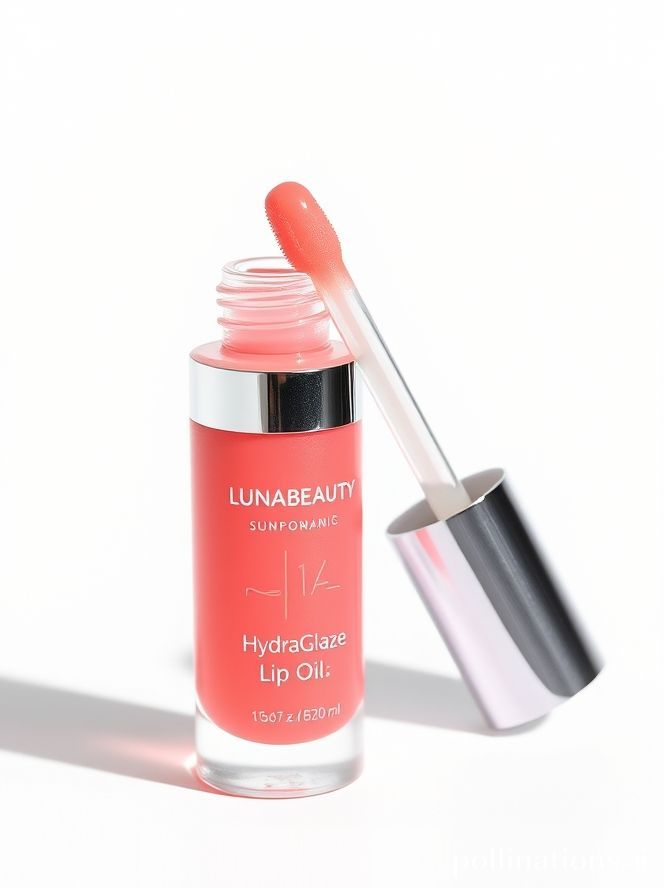

/tmp/ipython-input-933493561.py:161: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%d_%H%M%S")


Image 2 - Provider: pollinations


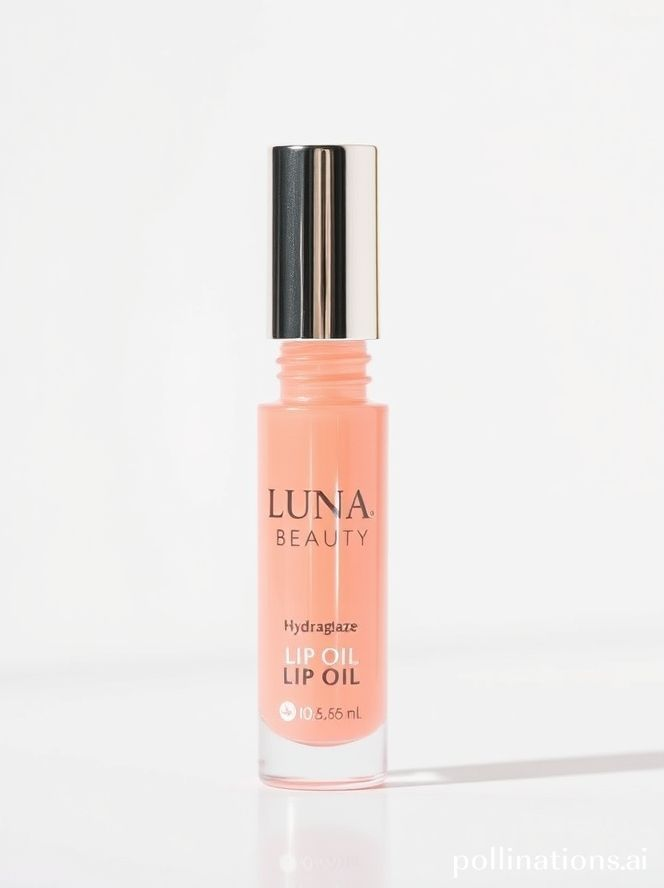

Image 3 - Provider: pollinations


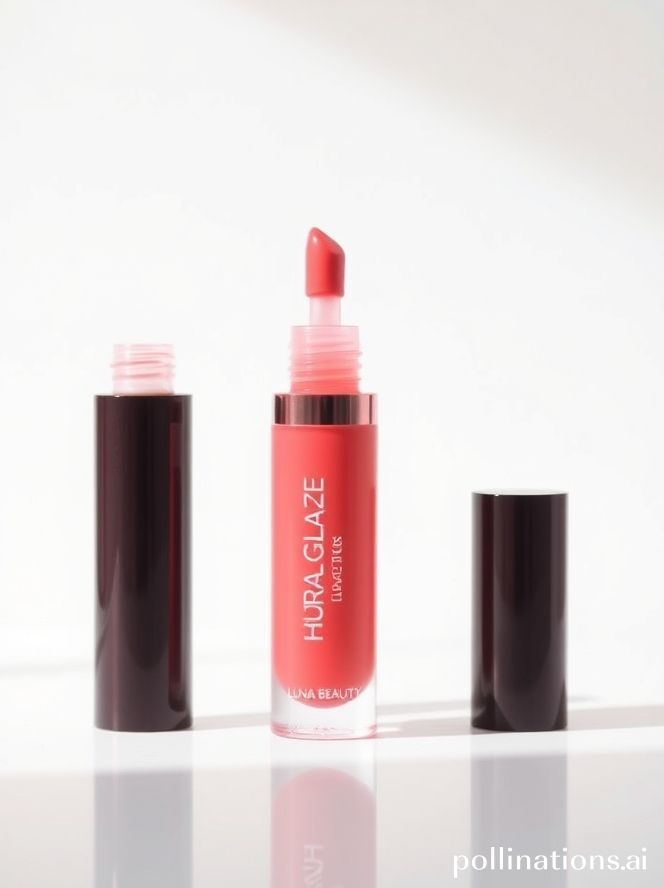


Saved files:
/content/outputs/pollinations_20250926_090123_1.png
/content/outputs/pollinations_20250926_090124_2.png
/content/outputs/pollinations_20250926_090124_3.png


In [34]:
# Step 6: Present results (display + save)
saved_paths = []

def show_caption(p):
    # Simple deterministic caption (no external LLM)
    top_benefits = ", ".join(p["benefits"][:2]) if p.get("benefits") else ""
    return f"{p['product_name']} — {p['message']} ({top_benefits})"

caption = show_caption(ui_params)
print("Caption:\n", caption, "\n")

for i, item in enumerate(images, start=1):
    provider = item.get("provider", "unknown")
    img = None
    if item.get("url"):
        try:
            img = download_image(item["url"])
        except Exception as e:
            print(f"[{provider}] Failed to download: {e}")
    elif item.get("b64"):
        try:
            raw = base64.b64decode(item["b64"])
            img = Image.open(BytesIO(raw)).convert("RGB")
        except Exception as e:
            print(f"[{provider}] Failed to decode b64: {e}")
    if img is not None:
        print(f"Image {i} - Provider: {provider}")
        display(img)
        path = save_image(img, provider, i)
        saved_paths.append(path)
    else:
        print(f"Image {i} - Provider: {provider} - No image content")

print("\nSaved files:")
for pth in saved_paths:
    print(pth)